In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import lightning as L

In [2]:
# torch.version.cuda
# print(torch.version.cuda)
# L.seed_everything(42)

Global seed set to 42


42

### Feature extraction

In [3]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
print(config['data']['frame_size'])

512


In [4]:
fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [5]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        self.X = np.zeros((20000, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:] = X_spec[:,n:n+supra_frame_length]
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:] = X_spec[:,n:n+supra_frame_length]
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


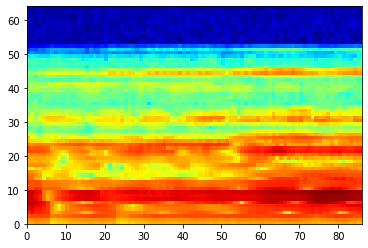

In [6]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(16200)

plt.pcolor(X_generic, cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)
# print(fold_0_train)
# print(fold_0_val)
# print(fold_0_test)

### NN-model

In [7]:
class ALS_FFNN(nn.Module):
    def __init__(self):
        super(ALS_FFNN,self).__init__() 
        # parameters
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        self.frames_in_segment = config['data']['supra_frame_length']
        self.drop1 = nn.Dropout(p=0.5)
        self.batch_norm1 = out = nn.BatchNorm1d(self.n_mel*self.frames_in_segment)
        self.fc = nn.Linear(self.n_mel*self.frames_in_segment,1)
        nn.init.xavier_uniform_(self.fc.weight, gain=1.0,)
    
    def forward(self, x):
        out = x.view(-1,self.n_mel*self.frames_in_segment)
        out = self.batch_norm1(out)
        out = self.drop1(out)
        out = self.fc(out)
        return out    

In [11]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/entire_model.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        model.train()
        best_acc = 0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)
            outputs = outputs.squeeze()            
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        # prediction on val set        
        val_score = list()
        loss_val = 0.0
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)
                pred = torch.squeeze(pred,1)                
                loss = loss_fn(pred, label)
                loss_val += loss.item()
                val_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)                        
                else:
                    pred = torch.tensor(0, dtype=torch.float64)
                if pred==label:
                    TP_TN_sum +=1
        acc_val = TP_TN_sum/len(val_score)    
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)

        if acc_val>best_acc:
            torch.save(model, MODEL_PATH)

        if epoch==1 or epoch%2==0:                                                            
            print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lr_scheduler.step()
        
    model = torch.load(MODEL_PATH)

    fig, ax = plt.subplots(figsize=(10,4))
    plt.rcParams.update({'font.size': 14})
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

### Single NN training & evaluation

Epoch 1: 100%|██████████| 250/250 [00:02<00:00, 120.96it/s]


2023-05-16 19:25:13.415427 Epoch 1, Train loss 0.725, Val loss 0.373, Acc_val = 0.88


Epoch 2: 100%|██████████| 250/250 [00:02<00:00, 119.17it/s]


2023-05-16 19:25:16.268505 Epoch 2, Train loss 0.552, Val loss 0.304, Acc_val = 0.88


Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 126.21it/s]


2023-05-16 19:25:21.685484 Epoch 4, Train loss 0.446, Val loss 0.259, Acc_val = 0.89


Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 125.27it/s]


2023-05-16 19:25:27.227616 Epoch 6, Train loss 0.401, Val loss 0.236, Acc_val = 0.91


Epoch 8: 100%|██████████| 250/250 [00:02<00:00, 124.14it/s]


2023-05-16 19:25:32.741234 Epoch 8, Train loss 0.360, Val loss 0.234, Acc_val = 0.91


Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 126.61it/s]


2023-05-16 19:25:38.237251 Epoch 10, Train loss 0.353, Val loss 0.232, Acc_val = 0.90


Epoch 12: 100%|██████████| 250/250 [00:01<00:00, 125.33it/s]


2023-05-16 19:25:43.733646 Epoch 12, Train loss 0.337, Val loss 0.246, Acc_val = 0.89


Epoch 14: 100%|██████████| 250/250 [00:02<00:00, 124.62it/s]


2023-05-16 19:25:49.337076 Epoch 14, Train loss 0.337, Val loss 0.221, Acc_val = 0.91


Epoch 16: 100%|██████████| 250/250 [00:01<00:00, 129.49it/s]


2023-05-16 19:25:54.810634 Epoch 16, Train loss 0.313, Val loss 0.253, Acc_val = 0.88


Epoch 18: 100%|██████████| 250/250 [00:01<00:00, 129.98it/s]


2023-05-16 19:26:00.208501 Epoch 18, Train loss 0.311, Val loss 0.234, Acc_val = 0.90


Epoch 20: 100%|██████████| 250/250 [00:01<00:00, 129.27it/s]


2023-05-16 19:26:05.667211 Epoch 20, Train loss 0.297, Val loss 0.239, Acc_val = 0.89


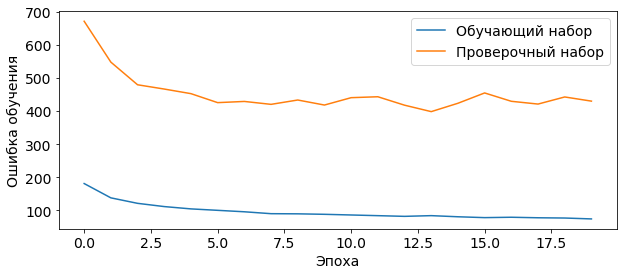

In [13]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

ALS_ffnn = ALS_FFNN()
ALS_ffnn.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(ALS_ffnn.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=ALS_ffnn,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

In [ ]:
ALS_ffnn.eval()

test_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_test_inds)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False) # num_workers=1

test_score = list()
TP_TN_sum = 0
with torch.no_grad():
    for spec, label in test_loader:
        spec = spec.float()
        spec = spec.squeeze()
        pred = ALS_ffnn(spec)
        test_score.append(pred.numpy())
        if pred>0:
            pred = torch.tensor(1, dtype=torch.float64)
        else:
            pred = torch.tensor(0, dtype=torch.float64)
            # print('Neg example')    
        if pred==label:
            TP_TN_sum +=1

print('Acc = ', TP_TN_sum/len(test_score))

test_score = np.array(test_score).squeeze()
plt.plot(test_score)

### Train with 5-fold CV

In [15]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)

    for i in range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                spec = spec.squeeze()
                pred = model(spec)
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### Start script

Epoch 1: 100%|██████████| 250/250 [00:02<00:00, 115.69it/s]


2023-05-16 19:31:35.532857 Epoch 1, Train loss 0.404, Val loss 0.277, Acc_val = 0.89


Epoch 2: 100%|██████████| 250/250 [00:02<00:00, 117.16it/s]


2023-05-16 19:31:38.472007 Epoch 2, Train loss 0.287, Val loss 0.256, Acc_val = 0.89


Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 127.77it/s]


2023-05-16 19:31:43.850451 Epoch 4, Train loss 0.242, Val loss 0.281, Acc_val = 0.89


Epoch 6: 100%|██████████| 250/250 [00:02<00:00, 124.17it/s]


2023-05-16 19:31:49.310334 Epoch 6, Train loss 0.236, Val loss 0.266, Acc_val = 0.87


Epoch 8: 100%|██████████| 250/250 [00:02<00:00, 122.72it/s]


2023-05-16 19:31:54.787639 Epoch 8, Train loss 0.235, Val loss 0.283, Acc_val = 0.89


Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 131.40it/s]


2023-05-16 19:32:00.148931 Epoch 10, Train loss 0.231, Val loss 0.291, Acc_val = 0.87


Epoch 12: 100%|██████████| 250/250 [00:01<00:00, 126.78it/s]


2023-05-16 19:32:05.590601 Epoch 12, Train loss 0.234, Val loss 0.290, Acc_val = 0.88


Epoch 14: 100%|██████████| 250/250 [00:01<00:00, 131.36it/s]


2023-05-16 19:32:11.009520 Epoch 14, Train loss 0.235, Val loss 0.284, Acc_val = 0.87


Epoch 15: 100%|██████████| 250/250 [00:01<00:00, 126.88it/s]


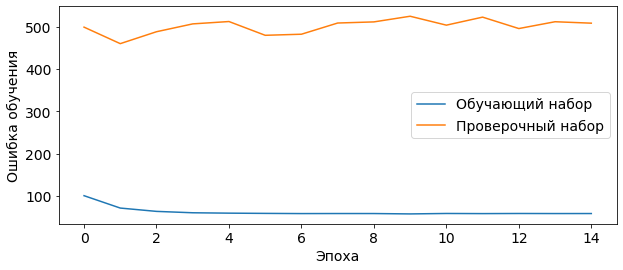

Acc =  0.767609126984127


Epoch 1: 100%|██████████| 274/274 [00:02<00:00, 123.59it/s]


2023-05-16 19:32:17.901887 Epoch 1, Train loss 0.424, Val loss 0.257, Acc_val = 0.85


Epoch 2: 100%|██████████| 274/274 [00:02<00:00, 125.43it/s]


2023-05-16 19:32:20.561355 Epoch 2, Train loss 0.289, Val loss 0.246, Acc_val = 0.88


Epoch 4: 100%|██████████| 274/274 [00:02<00:00, 126.61it/s]


2023-05-16 19:32:25.908022 Epoch 4, Train loss 0.231, Val loss 0.253, Acc_val = 0.83


Epoch 6: 100%|██████████| 274/274 [00:02<00:00, 129.73it/s]


2023-05-16 19:32:31.162512 Epoch 6, Train loss 0.210, Val loss 0.241, Acc_val = 0.89


Epoch 8: 100%|██████████| 274/274 [00:02<00:00, 128.33it/s]


2023-05-16 19:32:36.353896 Epoch 8, Train loss 0.200, Val loss 0.237, Acc_val = 0.84


Epoch 10: 100%|██████████| 274/274 [00:02<00:00, 131.50it/s]


2023-05-16 19:32:41.490319 Epoch 10, Train loss 0.193, Val loss 0.256, Acc_val = 0.77


Epoch 12: 100%|██████████| 274/274 [00:02<00:00, 126.16it/s]


2023-05-16 19:32:46.700908 Epoch 12, Train loss 0.187, Val loss 0.257, Acc_val = 0.87


Epoch 14: 100%|██████████| 274/274 [00:02<00:00, 129.73it/s]


2023-05-16 19:32:52.039400 Epoch 14, Train loss 0.185, Val loss 0.267, Acc_val = 0.76


Epoch 15: 100%|██████████| 274/274 [00:02<00:00, 126.12it/s]


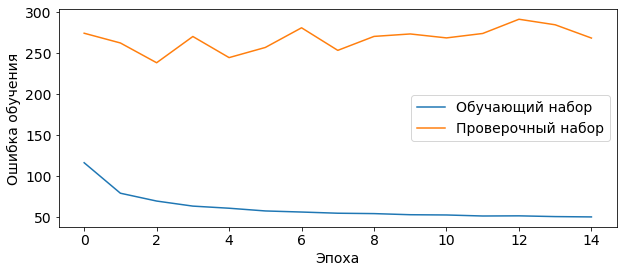

Acc =  0.751410835214447


Epoch 1: 100%|██████████| 254/254 [00:02<00:00, 124.67it/s]


2023-05-16 19:32:58.633222 Epoch 1, Train loss 0.545, Val loss 0.529, Acc_val = 0.69


Epoch 2: 100%|██████████| 254/254 [00:02<00:00, 124.29it/s]


2023-05-16 19:33:01.236365 Epoch 2, Train loss 0.440, Val loss 0.447, Acc_val = 0.81


Epoch 4: 100%|██████████| 254/254 [00:02<00:00, 124.50it/s]


2023-05-16 19:33:06.377984 Epoch 4, Train loss 0.381, Val loss 0.427, Acc_val = 0.82


Epoch 6: 100%|██████████| 254/254 [00:01<00:00, 128.47it/s]


2023-05-16 19:33:11.458105 Epoch 6, Train loss 0.353, Val loss 0.406, Acc_val = 0.83


Epoch 8: 100%|██████████| 254/254 [00:01<00:00, 128.24it/s]


2023-05-16 19:33:16.544023 Epoch 8, Train loss 0.334, Val loss 0.390, Acc_val = 0.83


Epoch 10: 100%|██████████| 254/254 [00:01<00:00, 131.05it/s]


2023-05-16 19:33:21.606983 Epoch 10, Train loss 0.326, Val loss 0.385, Acc_val = 0.84


Epoch 12: 100%|██████████| 254/254 [00:01<00:00, 131.69it/s]


2023-05-16 19:33:26.608027 Epoch 12, Train loss 0.319, Val loss 0.389, Acc_val = 0.83


Epoch 14: 100%|██████████| 254/254 [00:01<00:00, 127.51it/s]


2023-05-16 19:33:31.823895 Epoch 14, Train loss 0.315, Val loss 0.379, Acc_val = 0.84


Epoch 15: 100%|██████████| 254/254 [00:02<00:00, 121.87it/s]


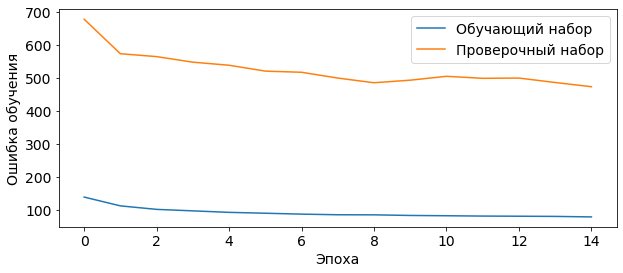

Acc =  0.6445672191528545


Epoch 1: 100%|██████████| 263/263 [00:02<00:00, 126.68it/s]


2023-05-16 19:33:38.583201 Epoch 1, Train loss 0.699, Val loss 0.811, Acc_val = 0.41


Epoch 2: 100%|██████████| 263/263 [00:02<00:00, 125.65it/s]


2023-05-16 19:33:41.117794 Epoch 2, Train loss 0.638, Val loss 0.801, Acc_val = 0.48


Epoch 4: 100%|██████████| 263/263 [00:02<00:00, 126.27it/s]


2023-05-16 19:33:46.172700 Epoch 4, Train loss 0.597, Val loss 0.809, Acc_val = 0.43


Epoch 6: 100%|██████████| 263/263 [00:02<00:00, 120.95it/s]


2023-05-16 19:33:51.371570 Epoch 6, Train loss 0.567, Val loss 0.767, Acc_val = 0.44


Epoch 8: 100%|██████████| 263/263 [00:01<00:00, 137.18it/s]


2023-05-16 19:33:56.179304 Epoch 8, Train loss 0.548, Val loss 0.802, Acc_val = 0.38


Epoch 10: 100%|██████████| 263/263 [00:02<00:00, 122.88it/s]


2023-05-16 19:34:01.440031 Epoch 10, Train loss 0.531, Val loss 0.771, Acc_val = 0.38


Epoch 12: 100%|██████████| 263/263 [00:01<00:00, 132.36it/s]


2023-05-16 19:34:06.360527 Epoch 12, Train loss 0.532, Val loss 0.764, Acc_val = 0.38


Epoch 14: 100%|██████████| 263/263 [00:02<00:00, 128.29it/s]


2023-05-16 19:34:11.340533 Epoch 14, Train loss 0.519, Val loss 0.748, Acc_val = 0.38


Epoch 15: 100%|██████████| 263/263 [00:02<00:00, 121.46it/s]


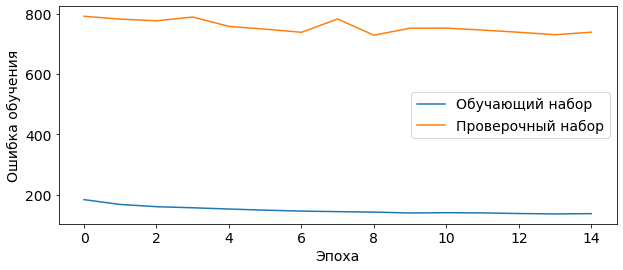

Acc =  0.7397778303001654


Epoch 1: 100%|██████████| 250/250 [00:02<00:00, 116.75it/s]


2023-05-16 19:34:18.554331 Epoch 1, Train loss 0.783, Val loss 0.702, Acc_val = 0.64


Epoch 2: 100%|██████████| 250/250 [00:02<00:00, 111.94it/s]


2023-05-16 19:34:21.613534 Epoch 2, Train loss 0.771, Val loss 0.684, Acc_val = 0.64


Epoch 4: 100%|██████████| 250/250 [00:02<00:00, 120.78it/s]


2023-05-16 19:34:27.474139 Epoch 4, Train loss 0.753, Val loss 0.667, Acc_val = 0.64


Epoch 6: 100%|██████████| 250/250 [00:02<00:00, 112.31it/s]


2023-05-16 19:34:33.749532 Epoch 6, Train loss 0.738, Val loss 0.662, Acc_val = 0.66


Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 126.36it/s]


2023-05-16 19:34:39.559680 Epoch 8, Train loss 0.726, Val loss 0.649, Acc_val = 0.66


Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 128.14it/s]


2023-05-16 19:34:45.075658 Epoch 10, Train loss 0.717, Val loss 0.640, Acc_val = 0.67


Epoch 12: 100%|██████████| 250/250 [00:01<00:00, 127.72it/s]


2023-05-16 19:34:50.557323 Epoch 12, Train loss 0.716, Val loss 0.631, Acc_val = 0.67


Epoch 14: 100%|██████████| 250/250 [00:02<00:00, 123.35it/s]


2023-05-16 19:34:56.125108 Epoch 14, Train loss 0.710, Val loss 0.616, Acc_val = 0.66


Epoch 15: 100%|██████████| 250/250 [00:02<00:00, 120.30it/s]


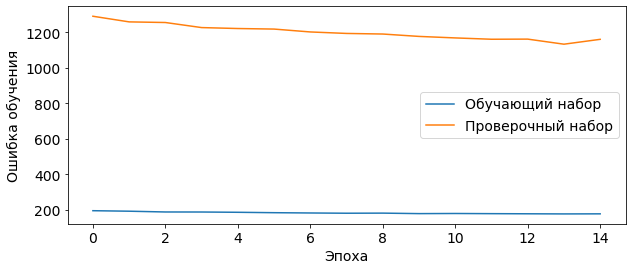

Acc =  0.479077925331997
Final results
Acc_sk = 0.66
Prec = 0.67
Recall = 0.66
Sens = 0.66
Spec = 0.66


0.6621333770276913

In [17]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
ALS_ffnn = ALS_FFNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(ALS_ffnn.parameters(),lr=1e-4, weight_decay=7e-1) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = ALS_ffnn, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

In [18]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))


torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
